# Cits4403 - Project

The simulation in this project aims to find out how epdidemic behaves in different scnerios.

## Setup

In [81]:
import numpy as np
import matplotlib.pyplot as plt

from os.path import basename, exists

# Download the base code provided that would be used by the simulation
# Retrieved from workshop exercises 7
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

## Epidemic Simulation

In [82]:
from Cell2D import Cell2D, draw_array
from scipy.signal import correlate2d
from enum import Enum

# Retrieved from workshop exercises 7
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.

    n: int number of rows
    m: int number of cols

    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

class Status(Enum):
    """ Represents the current status of a agent """

    HEALTHY=1
    INFECTED_LATENT=2
    INFECTED_ACTIVE=3
    DEAD=4

# The class for each agent or people in the simulation
class Agent():
    """ An agent in the simulation."""

    # The base infection resistance of agent
    def __init__(self, loc, infec_resist_low=0.3):
        # The position of the agent in the grid
        self.loc = tuple(loc)
        # The lowest resistance defines the immune system of a agent, differnt 
        # agent have different immunities
        self.infec_resist_low = np.random.uniform(0, infec_resist_low)
        # The resistance of the agent to the infection
        self.infec_resist = self.infec_resist_low
        # Represent of the agent is in lock down
        self.isLockDown = False
        # Represent infection condition of agent
        self.status = Status.HEALTHY
        # Array storing the number of days where agent gets infected latent and
        # active
        self.infec_latent_day = []
        self.infec_active_day = []

    def getLoc(self):
        """Return the agent's location"""

        return self.loc
    
    def infect(self, step_num):
        """Infect the agent"""

        self.status = Status.INFECTED_LATENT
        self.infec_latent_day.append(step_num)

    def step(self, sim, infec_prob):
        """ The agent performs a step, which updates its information """

        if self.status == Status.INFECTED_LATENT:
            # Infected latent agent becomes active
            if sim.step_num - self.infec_latent_day[-1] >= sim.latent_period:
                self.status = Status.INFECTED_ACTIVE
                self.infec_active_day.append(sim.step_num)
        elif self.status == Status.INFECTED_ACTIVE:
            # A agent with a better immune system will recover faster
            if sim.step_num - self.infec_active_day[-1] >= - \
            sim.recovery_period * (1 - self.infec_resist * 0.5):
                self.status = Status.HEALTHY
                self.infec_resist += sim.recovery_bonus
            # The active infection damages the agent as well, so every day/step 
            # there is chance of dying 
            elif np.random.uniform() < sum.fatal_rate:
                self.status = Status.DEAD
        elif self.status == Status.HEALTHY:
            # The agent can become infected based on the infec_prob, which is 
            # accumulative probability of infection based on neighborhood. A 
            # stronger immune system or infection reistence would also reduce 
            # the probability
            infected = np.random.uniform() < infec_prob * (1 - self.infec_resist)
            # If agent is lock down then another level of separation is applied 
            # hence the probability of getting infected is even lower
            infected = infected and not (self.isLockDown and np.random.uniform()
                                          < sim.lock_down_resist)
            if infected:
                self.infect(sim.step_num)
        
        # Agent may had a boost in immune system against the infection and 
        # decreases overtime until threadhold of the agent
        self.infec_resist = max(self.infec_resist_low, self.infec_resist -\
                                 sim.infec_resist_dec)

# Class represent the simulation of the epidemic in a town
class EpidemicSim(Cell2D):
    """Represent a epidemic simulation in a small town"""

    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)

    def __init__(self, n, pop, infec_prob=0.1, latent_period=10, fatal_rate=0.01,
                  recovery_period=10, infec_resist_dec=0.03, recovery_bonus=0.8,
                   agent_move_size=2, lock_down_resist=0.8, num_infect=100):
        # The grid size representing the size of the town
        self.n = n
        # The population, define to be max of half of the cells.
        self.pop = min(pop, int(n*n/2))
        # Defines how easy it is for the infections to spread
        self.infec_prob = infec_prob
        # Defines how long it takes for agent to be come infectious
        self.latent_period = latent_period
        # Defines how long it takes for agent to recover
        self.recovery_period = recovery_period
        # Defines how much the infection resistance for the agent decays over 
        # time. This is from the immune system after agent recovers
        self.infec_resist_dec = infec_resist_dec
        # The probability of a infected agent dying in a day
        self.fatal_rate = fatal_rate
        # The number of step currently
        self.step_num = 0
        # When agents recover, they become more resistent to the infection
        self.recovery_bonus = recovery_bonus
        # How far the agent can move in a square, 1 means agent have 8 possible 
        # spaces to move to each time step
        self.agent_move_size = agent_move_size
        move_grid_size = 1 + agent_move_size * 2
        # Contains the locations agent can move to if agent is at loc (0,0)
        self.origin_mov_locs = [(i[0] - agent_move_size, i[1] - agent_move_size)
                                 for i in make_locs(move_grid_size, move_grid_size)]
        # Means how much resistance against the infection if a person is in 
        # lockdown. This means they stay at home not moving and other may visit 
        # them an get them infected, but at much lower rate.
        self.lock_down_resist = lock_down_resist
        # Just used for drawing
        self.array = np.zeros((n,n))
        # Create the agents
        self.make_agents()
        # Infect some agents
        self.apply_infection(n=num_infect)

    def getAliveAgents(self):
        """ Get all alive agents """

        return [agent for agent in self.agents if agent.status != Status.DEAD]
    
    def getMoveableAgents(self):
        """Get all agents that can move"""

        return [agent for agent in self.agents if agent.status != Status.DEAD and not agent.isLockDown]
    
    def getInfectedAgents(self):
        """ Get all infected agents """

        return [agent for agent in self.agents if agent.status == 
                Status.INFECTED_LATENT or agent.status == Status.INFECTED_ACTIVE]

    def getAgentMoveableLoc(self, agent, agent_locs):
        """Find a new random location that the agent can move to"""

        # Find out positions the agent can move to
        agent_x = agent.loc[0]
        agent_y = agent.loc[1]
        # Shift of all the origin moveable locs baed on the agent loc
        agent_move_locs = [(loc[0] + agent_x, loc[1] + agent_y)
                            for loc in self.origin_mov_locs]
        # Agent will move randomly
        np.random.shuffle(agent_move_locs)
        # Location should not clash with other agents
        for loc in agent_move_locs:
            if loc[0] < self.n and loc[1] < self.n and loc not in agent_locs:
                return loc
        return None

    def step(self):
        """Executes one time step, representing one day"""
        
        # A new day
        self.step_num += 1
        infected_agents = self.getInfectedAgents()
        # Get 2d cell of the 
        cells_infec_probs = np.zeros((self.n, self.n))
        # Find the infected agents to create a 2d grid of probabilities. This 
        # is then used to apply rule to find the probability of each cell 
        # getting infected.
        for agent in infected_agents:
            cells_infec_probs[agent.loc] = self.infec_prob
        cells_infec_probs_corr = correlate2d(cells_infec_probs, self.kernel,
                                             **self.options)
        # Each agent will update every step with the corresponding probabilities
        #  of infection passed
        for agent in self.agents:
            agent.step(self, cells_infec_probs_corr[agent.loc])
        agent_locs = [agent.loc for agent in self.agents]
        # Move the agent
        for agent in self.getMoveableAgents():
            new_loc = self.getAgentMoveableLoc(agent, agent_locs)
            # None means agent has no place to move
            if new_loc is not None:
                # Update agent locations
                agent_locs.remove(agent.loc)
                agent_locs.append(new_loc)
                agent.loc = new_loc

    def apply_vaccine(self, p=0.6, vaccine_effect=0.6):
        """Pretend agents took vaccine, by improving the infection resistance of
            agents in the simulation by probability of p"""
        
        # Agent will have improved infection resistance
        for agent in self.agents:
            if np.random.uniform() < p:
                agent.infec_resist += vaccine_effect

    def apply_lockdown(self, p=0.6):
        """Apply lockdown to agents based on p as the probability"""

        for agent in self.agents:
            if np.random.uniform() < p:
                agent.isLockDown = True

    def apply_infection(self, n=100):
        """Try make n number of the agents infected active"""

        # Not exactly n number are infected, one could be set as infected more 
        # than once
        actual_n = min(n, len(self.agents))
        for i in range(actual_n):
            agent = np.random.choice(self.agents)
            agent.infect(0)

    def make_agents(self):
        """Create agents in the simulation"""

        # Location of the agents is genereted randomly, the method is learnt
        # from the workshop exercises 7
        locs = make_locs(self.n, self.n)
        np.random.shuffle(locs)

        # Generated pop field nubmer of agents each taking the random shuffled
        # locations created
        self.agents = [Agent(locs[i]) for i in range(self.pop)]
        
    # Retrieved from the workshop exercises 7
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        # Draw agents based on the status
        xs_h, ys_h = self.get_coords(status=Status.HEALTHY)
        plt.plot(xs_h, ys_h, '.', color='green')[0]
        xs_i, ys_i = self.get_coords(status=Status.INFECTED_LATENT)
        plt.plot(xs_i, ys_i, '.', color="orange")[0]
        xs_i, ys_i = self.get_coords(status=Status.INFECTED_ACTIVE)
        plt.plot(xs_i, ys_i, '.', color="red")[0]
        xs_i, ys_i = self.get_coords(status=Status.DEAD)
        plt.plot(xs_i, ys_i, '.', color="black")[0]


    # Retrieved from the workshop exercises 7
    def get_coords(self, status=Status.HEALTHY):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        filtered_agents = [agent.getLoc() for agent in agents if agent.status == status]
        if len(filtered_agents) == 0:
            return [], []
        rows, cols = np.transpose(filtered_agents)
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

    

## Running the simulation

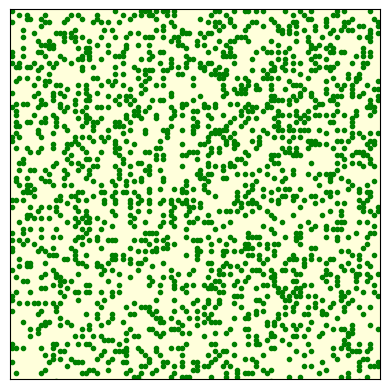

In [86]:
np.random.seed(12345678)
sim = EpidemicSim(n=100, pop=2000, num_infect=300)
sim.apply_vaccine()
sim.apply_lockdown()
sim.animate(frames=300)